# Collision likelihood

Let's consider a multi-device IoT scenario with both Poisson HMMs and Discrete HMMs.
The challenge of detecting collision likelihood becomes a structured learning problem.

### Problem Definition

- Inputs: Base station sees a time series of observed signals with possible collisions.

- Goal: Learn a model that predicts the probability of collision at each time step.

- Devices:
    - 20 devices with categorical emissions (e.g., Discrete HMM).
    - 5 devices with count-based Poisson emissions (e.g., Poisson HMM).

In [1]:
%%capture
!pip install scikit-learn
!pip install torch
!pip install tqdm

In [2]:
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
np.random.seed(42)

## Step 1: Simulate Emissions

Simulate each device independently.

Sum up emissions and apply a collision function: If more than one device emits at the same time → collision Else → base station sees total emission.

In [4]:
from devices import SimpleHMM as DiscreteHMM
from devices import PoissonHMM

In [5]:
# Parameters
T = 1000
n_discrete = 20
n_poisson = 5

# HMM models (same for all devices of each type)
A_disc = np.array([[0.97, 0.03],   # idle → idle with high probability
                   [0.7, 0.3]])    # active → idle more likely than staying active

B_disc = np.array([[0.99, 0.01, 0.0],   # idle emits 0 with very high probability
                   [0.7, 0.25, 0.05]])  # active: mostly emits 0–1, rarely 2
pi_disc = [1.0, 0.0]

# Poisson-based HMM
A_pois = np.array([[0.98, 0.02],   # idle → idle is very likely
                   [0.6, 0.4]])    # active → idle more likely than staying active

lambda_pois = [0.05, 1.0]          # lower emission intensity

pi_pois = [1.0, 0.0]

In [6]:
def sample_discrete_hmm(T):
    device = DiscreteHMM(A_disc, B_disc, pi_disc)
    states, emissions = device.sample(T)
    return emissions

def sample_poisson_hmm(T):
    device = PoissonHMM(A_pois, lambda_pois, pi_pois)
    states, emissions = device.sample(T)
    return emissions  

In [7]:
# Generate emissions from all devices
emissions = []
for _ in range(n_discrete):
    emissions.append(sample_discrete_hmm(T))
for _ in range(n_poisson):
    emissions.append(sample_poisson_hmm(T))
emissions = np.array(emissions)

## Step 2: Create Dataset

For each time step:
- Input: scalar total emission (combined_obs[t])
- Label: 1 if collision occurred, 0 otherwise.

In [8]:
# Base station view: sum + collision label
total_emission = emissions.sum(axis=0)
active_devices = (emissions > 0).sum(axis=0)

collisions = (active_devices > 1).astype(int)

In [9]:
# Create features: [total_emission, num_active_devices (optional)]
X = total_emission.reshape(-1, 1)  # or np.vstack((total_emission, active_devices)).T
y = collisions

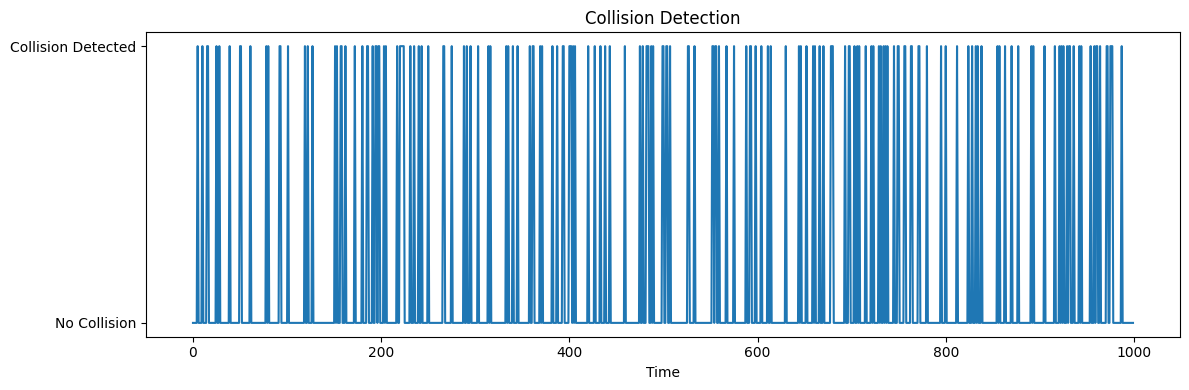

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(y, label="True collisions")
plt.xlabel("Time")
plt.yticks([0, 1], ['No Collision', 'Collision Detected'])
plt.title("Collision Detection")
# plt.legend()
plt.tight_layout()
plt.show()

# Step 3: Train a Model

Train a DL model (*e.g.* RNN or transformed) to classify collision likelihood from the observable signal.

We keep the input as a sliding window of emissions (past n steps).
We also use a lightweight Transformer encoder to process sequences.

The model is trained as a binary classifier: collision (1) vs no collision (0).

In [11]:
n_context = 10  # number of time steps to consider in the classification

In [12]:
T_effective = T - n_context + 1

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# Create input features
X = []
y = []

for t in range(n_context - 1, T):
    window = total_emission[t - n_context + 1: t + 1]
    X.append(window)
    y.append(collisions[t])

X = np.array(X)
y = np.array(y)

In [15]:
# Split into train/test

split = int(0.8 * len(X))
X_train = torch.tensor(X[:split], dtype=torch.float32).unsqueeze(-1).to(device)  # [B, T, 1]
y_train = torch.tensor(y[:split], dtype=torch.float32).to(device)

X_test = torch.tensor(X[split:], dtype=torch.float32).unsqueeze(-1).to(device)
y_test = torch.tensor(y[split:], dtype=torch.float32).to(device)

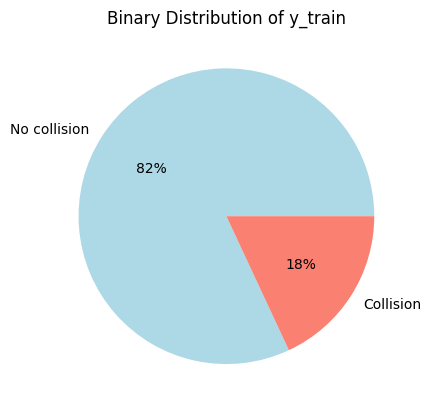

In [29]:
# Count occurrences of each category
labels, counts = np.unique(y_train.cpu().numpy(), return_counts=True)

# Create pie chart
plt.pie(counts, labels=["No collision" if int(x) == 0 else "Collision" for x in labels], autopct='%1.0f%%', colors=['lightblue', 'salmon'])

# Add title
plt.title('Binary Distribution of y_train')
plt.show()

## Model

In [30]:
# Transformer-based model
class CollisionTransformer(nn.Module):
    
    def __init__(self, input_dim=1, d_model=16, nhead=2, num_layers=2, use_sigmoid=False):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls = nn.Linear(d_model, 1)
        self.use_sigmoid = use_sigmoid

    def forward(self, x):
        x = self.input_proj(x)                     # [B, T, d_model]
        x = self.transformer(x)                    # [B, T, d_model]
        x = x.mean(dim=1)                          # global average pooling over time
        x = self.cls(x).squeeze(-1)                # [B]
        if self.use_sigmoid:
            return torch.sigmoid(x)
        else:
            return x

In [31]:
# Instantiate
lr = 0.0001

model = CollisionTransformer(nhead=4, num_layers=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss_fn = nn.BCELoss()

# to try to fix unbalanced data
pos_weight = torch.tensor([ (y_train == 0).sum() / (y_train == 1).sum() ]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Note: Remove sigmoid from model!

In [32]:
# Training loop
epochs = 500
losses = []
n_steps_show = epochs // 10
for epoch in tqdm(range(epochs)):
    model.train()
    pred = model(X_train)
    loss = loss_fn(pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if (epoch + 1) % n_steps_show == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

  1%|█▏                                                                                 | 7/500 [00:00<00:47, 10.40it/s]

Epoch 5, Loss: 1.1186


  2%|█▊                                                                                | 11/500 [00:01<00:42, 11.62it/s]

Epoch 10, Loss: 1.0809


  3%|██▊                                                                               | 17/500 [00:01<00:39, 12.30it/s]

Epoch 15, Loss: 1.0590


  4%|███▍                                                                              | 21/500 [00:01<00:38, 12.49it/s]

Epoch 20, Loss: 1.0472


  5%|████▍                                                                             | 27/500 [00:02<00:37, 12.58it/s]

Epoch 25, Loss: 1.0331


  6%|█████                                                                             | 31/500 [00:02<00:37, 12.59it/s]

Epoch 30, Loss: 1.0248


  7%|██████                                                                            | 37/500 [00:03<00:36, 12.62it/s]

Epoch 35, Loss: 1.0238


  8%|██████▋                                                                           | 41/500 [00:03<00:36, 12.62it/s]

Epoch 40, Loss: 1.0199


  9%|███████▋                                                                          | 47/500 [00:03<00:35, 12.68it/s]

Epoch 45, Loss: 1.0103


 10%|████████▎                                                                         | 51/500 [00:04<00:35, 12.64it/s]

Epoch 50, Loss: 1.0000


 11%|█████████▎                                                                        | 57/500 [00:04<00:34, 12.67it/s]

Epoch 55, Loss: 1.0032


 12%|██████████                                                                        | 61/500 [00:05<00:34, 12.68it/s]

Epoch 60, Loss: 1.0048


 13%|██████████▉                                                                       | 67/500 [00:05<00:34, 12.70it/s]

Epoch 65, Loss: 1.0078


 14%|███████████▋                                                                      | 71/500 [00:05<00:33, 12.66it/s]

Epoch 70, Loss: 1.0007


 15%|████████████▋                                                                     | 77/500 [00:06<00:33, 12.67it/s]

Epoch 75, Loss: 0.9977


 16%|█████████████▎                                                                    | 81/500 [00:06<00:33, 12.66it/s]

Epoch 80, Loss: 0.9962


 17%|██████████████▎                                                                   | 87/500 [00:07<00:32, 12.68it/s]

Epoch 85, Loss: 0.9928


 18%|██████████████▉                                                                   | 91/500 [00:07<00:32, 12.67it/s]

Epoch 90, Loss: 1.0001


 19%|███████████████▉                                                                  | 97/500 [00:07<00:31, 12.65it/s]

Epoch 95, Loss: 1.0002


 20%|████████████████▎                                                                | 101/500 [00:08<00:31, 12.64it/s]

Epoch 100, Loss: 0.9950


 21%|█████████████████▎                                                               | 107/500 [00:08<00:31, 12.65it/s]

Epoch 105, Loss: 1.0030


 22%|█████████████████▉                                                               | 111/500 [00:09<00:30, 12.66it/s]

Epoch 110, Loss: 0.9936


 23%|██████████████████▉                                                              | 117/500 [00:09<00:30, 12.67it/s]

Epoch 115, Loss: 0.9998


 24%|███████████████████▌                                                             | 121/500 [00:09<00:29, 12.65it/s]

Epoch 120, Loss: 0.9999


 25%|████████████████████▌                                                            | 127/500 [00:10<00:29, 12.64it/s]

Epoch 125, Loss: 0.9960


 26%|█████████████████████▏                                                           | 131/500 [00:10<00:29, 12.64it/s]

Epoch 130, Loss: 1.0033


 27%|██████████████████████▏                                                          | 137/500 [00:11<00:28, 12.65it/s]

Epoch 135, Loss: 0.9954


 28%|██████████████████████▊                                                          | 141/500 [00:11<00:28, 12.64it/s]

Epoch 140, Loss: 0.9979


 29%|███████████████████████▊                                                         | 147/500 [00:11<00:27, 12.65it/s]

Epoch 145, Loss: 0.9939


 30%|████████████████████████▍                                                        | 151/500 [00:12<00:27, 12.66it/s]

Epoch 150, Loss: 0.9964


 31%|█████████████████████████▍                                                       | 157/500 [00:12<00:27, 12.65it/s]

Epoch 155, Loss: 0.9929


 32%|██████████████████████████                                                       | 161/500 [00:12<00:26, 12.67it/s]

Epoch 160, Loss: 0.9932


 33%|███████████████████████████                                                      | 167/500 [00:13<00:26, 12.56it/s]

Epoch 165, Loss: 0.9925


 34%|███████████████████████████▋                                                     | 171/500 [00:13<00:26, 12.63it/s]

Epoch 170, Loss: 0.9974


 35%|████████████████████████████▋                                                    | 177/500 [00:14<00:25, 12.65it/s]

Epoch 175, Loss: 0.9955


 36%|█████████████████████████████▎                                                   | 181/500 [00:14<00:25, 12.63it/s]

Epoch 180, Loss: 0.9925


 37%|██████████████████████████████▎                                                  | 187/500 [00:15<00:24, 12.64it/s]

Epoch 185, Loss: 0.9937


 38%|██████████████████████████████▉                                                  | 191/500 [00:15<00:24, 12.63it/s]

Epoch 190, Loss: 0.9946


 39%|███████████████████████████████▉                                                 | 197/500 [00:15<00:24, 12.62it/s]

Epoch 195, Loss: 0.9949


 40%|████████████████████████████████▌                                                | 201/500 [00:16<00:23, 12.63it/s]

Epoch 200, Loss: 0.9852


 41%|█████████████████████████████████▌                                               | 207/500 [00:16<00:23, 12.63it/s]

Epoch 205, Loss: 0.9903


 42%|██████████████████████████████████▏                                              | 211/500 [00:16<00:22, 12.65it/s]

Epoch 210, Loss: 0.9857


 43%|███████████████████████████████████▏                                             | 217/500 [00:17<00:22, 12.63it/s]

Epoch 215, Loss: 0.9914


 44%|███████████████████████████████████▊                                             | 221/500 [00:17<00:22, 12.65it/s]

Epoch 220, Loss: 0.9900


 45%|████████████████████████████████████▊                                            | 227/500 [00:18<00:21, 12.63it/s]

Epoch 225, Loss: 0.9840


 46%|█████████████████████████████████████▍                                           | 231/500 [00:18<00:21, 12.64it/s]

Epoch 230, Loss: 0.9843


 47%|██████████████████████████████████████▍                                          | 237/500 [00:18<00:20, 12.64it/s]

Epoch 235, Loss: 0.9881


 48%|███████████████████████████████████████                                          | 241/500 [00:19<00:20, 12.65it/s]

Epoch 240, Loss: 0.9870


 49%|████████████████████████████████████████                                         | 247/500 [00:19<00:20, 12.64it/s]

Epoch 245, Loss: 0.9871


 50%|████████████████████████████████████████▋                                        | 251/500 [00:20<00:19, 12.62it/s]

Epoch 250, Loss: 0.9961


 51%|█████████████████████████████████████████▋                                       | 257/500 [00:20<00:19, 12.63it/s]

Epoch 255, Loss: 0.9862


 52%|██████████████████████████████████████████▎                                      | 261/500 [00:20<00:18, 12.60it/s]

Epoch 260, Loss: 0.9881


 53%|███████████████████████████████████████████▎                                     | 267/500 [00:21<00:18, 12.60it/s]

Epoch 265, Loss: 0.9840


 54%|███████████████████████████████████████████▉                                     | 271/500 [00:21<00:18, 12.60it/s]

Epoch 270, Loss: 0.9918


 55%|████████████████████████████████████████████▊                                    | 277/500 [00:22<00:17, 12.61it/s]

Epoch 275, Loss: 0.9892


 56%|█████████████████████████████████████████████▌                                   | 281/500 [00:22<00:17, 12.63it/s]

Epoch 280, Loss: 0.9854


 57%|██████████████████████████████████████████████▍                                  | 287/500 [00:22<00:16, 12.61it/s]

Epoch 285, Loss: 0.9786


 58%|███████████████████████████████████████████████▏                                 | 291/500 [00:23<00:16, 12.61it/s]

Epoch 290, Loss: 0.9866


 59%|████████████████████████████████████████████████                                 | 297/500 [00:23<00:16, 12.63it/s]

Epoch 295, Loss: 0.9843


 60%|████████████████████████████████████████████████▊                                | 301/500 [00:24<00:15, 12.62it/s]

Epoch 300, Loss: 0.9887


 61%|█████████████████████████████████████████████████▋                               | 307/500 [00:24<00:15, 12.61it/s]

Epoch 305, Loss: 0.9837


 62%|██████████████████████████████████████████████████▍                              | 311/500 [00:24<00:14, 12.62it/s]

Epoch 310, Loss: 0.9736


 63%|███████████████████████████████████████████████████▎                             | 317/500 [00:25<00:14, 12.64it/s]

Epoch 315, Loss: 0.9749


 64%|████████████████████████████████████████████████████                             | 321/500 [00:25<00:14, 12.60it/s]

Epoch 320, Loss: 0.9769


 65%|████████████████████████████████████████████████████▉                            | 327/500 [00:26<00:13, 12.60it/s]

Epoch 325, Loss: 0.9717


 66%|█████████████████████████████████████████████████████▌                           | 331/500 [00:27<00:29,  5.73it/s]

Epoch 330, Loss: 0.9833


 67%|██████████████████████████████████████████████████████▌                          | 337/500 [00:27<00:18,  8.92it/s]

Epoch 335, Loss: 0.9725


 68%|███████████████████████████████████████████████████████▏                         | 341/500 [00:28<00:15, 10.49it/s]

Epoch 340, Loss: 0.9784


 69%|████████████████████████████████████████████████████████▏                        | 347/500 [00:28<00:12, 11.79it/s]

Epoch 345, Loss: 0.9780


 70%|████████████████████████████████████████████████████████▊                        | 351/500 [00:28<00:12, 12.17it/s]

Epoch 350, Loss: 0.9688


 71%|█████████████████████████████████████████████████████████▊                       | 357/500 [00:29<00:11, 12.45it/s]

Epoch 355, Loss: 0.9845


 72%|██████████████████████████████████████████████████████████▍                      | 361/500 [00:29<00:11, 12.53it/s]

Epoch 360, Loss: 0.9740


 73%|███████████████████████████████████████████████████████████▍                     | 367/500 [00:30<00:10, 12.59it/s]

Epoch 365, Loss: 0.9824


 74%|████████████████████████████████████████████████████████████                     | 371/500 [00:30<00:10, 12.60it/s]

Epoch 370, Loss: 0.9808


 75%|█████████████████████████████████████████████████████████████                    | 377/500 [00:30<00:09, 12.60it/s]

Epoch 375, Loss: 0.9760


 76%|█████████████████████████████████████████████████████████████▋                   | 381/500 [00:31<00:09, 12.58it/s]

Epoch 380, Loss: 0.9763


 77%|██████████████████████████████████████████████████████████████▋                  | 387/500 [00:31<00:08, 12.60it/s]

Epoch 385, Loss: 0.9657


 78%|███████████████████████████████████████████████████████████████▎                 | 391/500 [00:32<00:08, 12.58it/s]

Epoch 390, Loss: 0.9704


 79%|████████████████████████████████████████████████████████████████▎                | 397/500 [00:32<00:08, 12.59it/s]

Epoch 395, Loss: 0.9742


 80%|████████████████████████████████████████████████████████████████▉                | 401/500 [00:32<00:07, 12.59it/s]

Epoch 400, Loss: 0.9710


 81%|█████████████████████████████████████████████████████████████████▉               | 407/500 [00:33<00:07, 12.59it/s]

Epoch 405, Loss: 0.9815


 82%|██████████████████████████████████████████████████████████████████▌              | 411/500 [00:33<00:07, 12.60it/s]

Epoch 410, Loss: 0.9637


 83%|███████████████████████████████████████████████████████████████████▌             | 417/500 [00:34<00:06, 12.60it/s]

Epoch 415, Loss: 0.9723


 84%|████████████████████████████████████████████████████████████████████▏            | 421/500 [00:34<00:06, 12.56it/s]

Epoch 420, Loss: 0.9808


 85%|█████████████████████████████████████████████████████████████████████▏           | 427/500 [00:34<00:05, 12.60it/s]

Epoch 425, Loss: 0.9878


 86%|█████████████████████████████████████████████████████████████████████▊           | 431/500 [00:35<00:05, 12.60it/s]

Epoch 430, Loss: 0.9761


 87%|██████████████████████████████████████████████████████████████████████▊          | 437/500 [00:35<00:04, 12.62it/s]

Epoch 435, Loss: 0.9742


 88%|███████████████████████████████████████████████████████████████████████▍         | 441/500 [00:36<00:04, 12.60it/s]

Epoch 440, Loss: 0.9671


 89%|████████████████████████████████████████████████████████████████████████▍        | 447/500 [00:36<00:04, 12.86it/s]

Epoch 445, Loss: 0.9778


 90%|█████████████████████████████████████████████████████████████████████████        | 451/500 [00:36<00:03, 13.11it/s]

Epoch 450, Loss: 0.9748


 91%|██████████████████████████████████████████████████████████████████████████       | 457/500 [00:37<00:03, 13.25it/s]

Epoch 455, Loss: 0.9829


 92%|██████████████████████████████████████████████████████████████████████████▋      | 461/500 [00:37<00:02, 13.29it/s]

Epoch 460, Loss: 0.9708


 93%|███████████████████████████████████████████████████████████████████████████▋     | 467/500 [00:38<00:02, 13.34it/s]

Epoch 465, Loss: 0.9773


 94%|████████████████████████████████████████████████████████████████████████████▎    | 471/500 [00:38<00:02, 13.35it/s]

Epoch 470, Loss: 0.9640


 95%|█████████████████████████████████████████████████████████████████████████████▎   | 477/500 [00:38<00:01, 13.36it/s]

Epoch 475, Loss: 0.9641


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 481/500 [00:39<00:01, 13.35it/s]

Epoch 480, Loss: 0.9655


 97%|██████████████████████████████████████████████████████████████████████████████▉  | 487/500 [00:39<00:00, 13.36it/s]

Epoch 485, Loss: 0.9552


 98%|███████████████████████████████████████████████████████████████████████████████▌ | 491/500 [00:39<00:00, 13.37it/s]

Epoch 490, Loss: 0.9655


 99%|████████████████████████████████████████████████████████████████████████████████▌| 497/500 [00:40<00:00, 13.38it/s]

Epoch 495, Loss: 0.9682


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:40<00:00, 12.35it/s]

Epoch 500, Loss: 0.9661


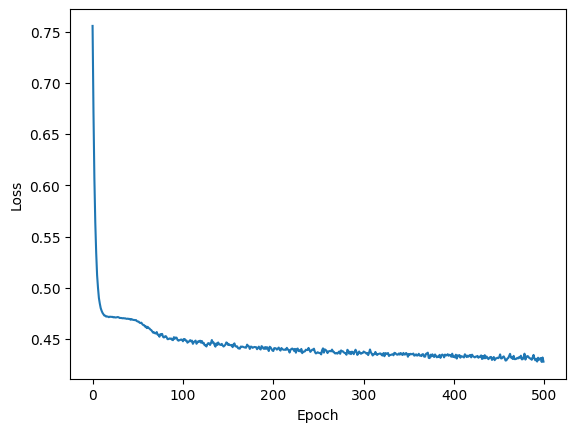

In [19]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [20]:
# Evaluate
model.eval()
with torch.no_grad():
    y_pred = model(X_test).cpu().numpy()
    y_pred_cls = (y_pred > 0.5).astype(int)
    y_true = y_test.cpu().numpy()

print(classification_report(y_true, y_pred_cls))

              precision    recall  f1-score   support

         0.0       0.82      0.99      0.90       164
         1.0       0.00      0.00      0.00        35

    accuracy                           0.82       199
   macro avg       0.41      0.50      0.45       199
weighted avg       0.68      0.82      0.74       199



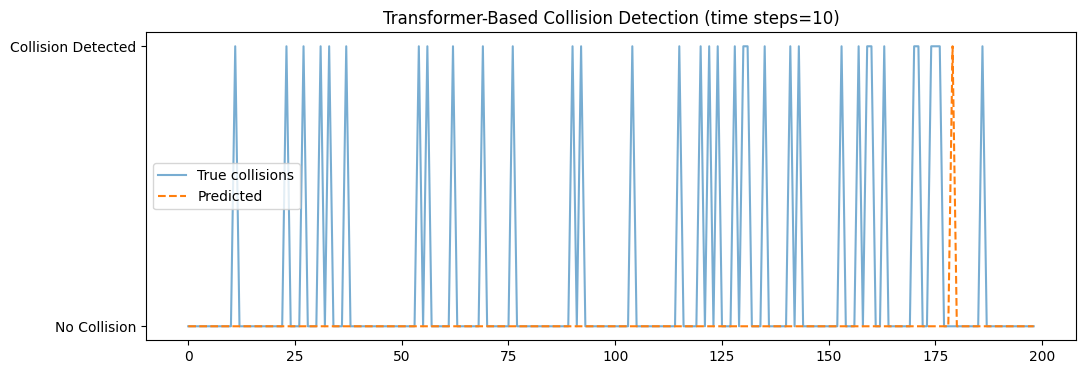

In [21]:
# Plot results
plt.figure(figsize=(12, 4))
plt.plot(y_true, label="True collisions", alpha=0.6)
plt.plot(y_pred_cls, label="Predicted", linestyle='--')
plt.yticks([0, 1], ['No Collision', 'Collision Detected'])
plt.legend()
plt.title(f"Transformer-Based Collision Detection (time steps={n_context})")
plt.show()

In [35]:
from sklearn.metrics import roc_auc_score, average_precision_score

print("AUC:", roc_auc_score(y_test.cpu(), y_pred_cls))
print("PR AUC:", average_precision_score(y_test.cpu(), y_pred_cls))

AUC: 0.4969512195121951
PR AUC: 0.17587939698492464


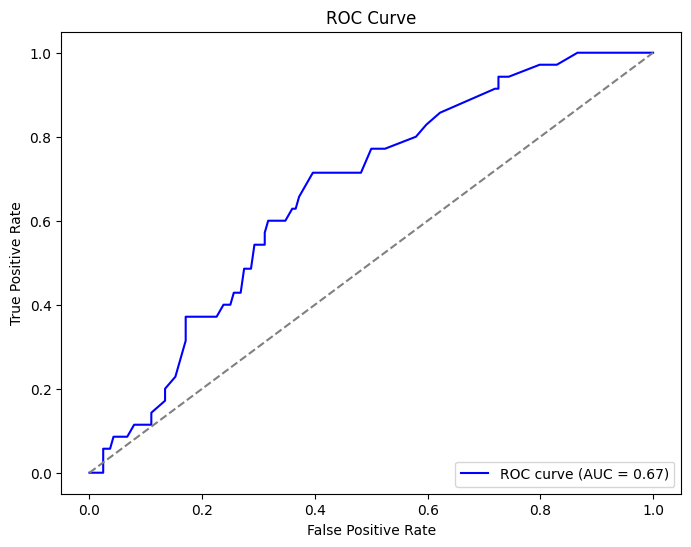

In [37]:
from sklearn.metrics import roc_curve, auc

y_scores = torch.sigmoid(torch.tensor(y_pred)).numpy() 

fpr, tpr, _ = roc_curve(y_test.cpu(), y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

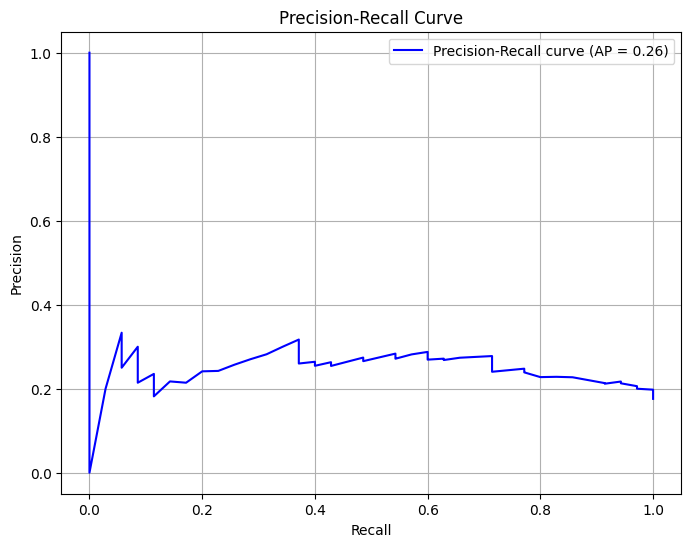

In [39]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test.cpu(), y_scores)

# Compute Average Precision (AP) score
ap_score = average_precision_score(y_test.cpu(), y_scores)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()